# Fast LISA Response Tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import h5py
from fastlisaresponse import pyResponseTDI, ResponseWrapper
from astropy import units as un

YRSID_SI = 31558149.763545603

This tutorial provides information on using `fastlisaresponse`: a generic time-domain LISA response function, including both projection on to constellation arms and TDI combinations. It is also GPU/CPU agnostic. The GPU capability is helpful for use in Bayesian inference algorithms. For more information and a detailed API, please see the [documentation](https://mikekatz04.github.io/lisa-on-gpu/).

If you use this code, please cite (#TODO: add paper) and the code's Zenodo page (#TODO: add zenodo). 

## Orbits

A few files are included with the Github repository. Orbits can also be generated with the LDC orbit module

Let's look at `esa-trailing-orbits.h5` and `equalarmlength-trailing-fit.h5`. If you build an orbit file, it needs to be of the same form as these files. 

In [2]:
out_esa = {}
with h5py.File("../orbit_files/esa-trailing-orbits.h5", "r") as f:
    for key in f["tcb"]:
        out_esa[key] = f["tcb"][key][:]
        
out_equal = {}
with h5py.File("../orbit_files/equalarmlength-trailing-fit.h5", "r") as f:
    for key in f["tcb"]:
        out_equal[key] = f["tcb"][key][:]

This gives the link information as `l_ij` where `i` is the emitting spacecraft and `j` is the receiver; the spacecraft information as `sc_k`; and the time array associated with these quantities(`t`).

In [3]:
out_esa.keys()

dict_keys(['l_12', 'l_13', 'l_21', 'l_23', 'l_31', 'l_32', 'sc_1', 'sc_2', 'sc_3', 't'])

### Link information

The link information gives the delay time (`tt`); #TODO fill out; and the vector pointing from the emitter to the receiver (`nx`, `ny`, `nz`). 

In [4]:
out_esa["l_12"].dtype.names

('tt', 'ppr', 'd_tt', 'd_ppr', 'nx', 'ny', 'nz')

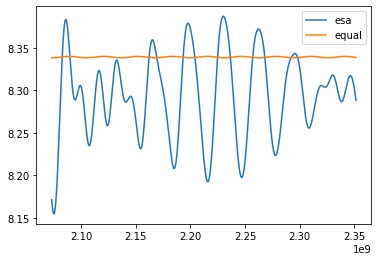

In [5]:
plt.plot(out_esa["t"], out_esa["l_12"]["tt"], label='esa')
plt.plot(out_equal["t"], out_equal["l_12"]["tt"], label='equal')
plt.legend()
#plt.savefig("esa_equalarm_l_12.png")

## Gravitational wave signal

 `fastlisaresponse` takes any time domain signal in the form $h(t) = h_+ + ih_\times$. We are going to use a Galactic binary waveform given by
 
$$
    h_{+,\text{src}} = -A(1+\cos^2{\iota})\cos{\Phi(t)}\qquad \text{          and} 
$$

$$
    h_{\times,\text{src}} = -2A\cos{\iota}\sin{\Phi(t)} \text{  ,}
$$

where $A$ is the amplitude; $\iota$ is the inclination; and
$$\Phi(t) \approx -\phi_0 + 2\pi \left(ft + \frac{1}{2}\dot{f}t^2 + \frac{1}{6}\ddot{f}t^3 \right).$$

$f$ is the initial gravitational wave frequency, and the over-dots are its time derivatives. The initial phase is $\phi_0$. 

This waveform is then transformed to the solar-system barycenter (SSB) frame with the polarization angle, $\psi$:

$$
    \begin{bmatrix}
        h_{+,\text{SSB}} \\
        h_{\times,\text{SSB}} 
     \end{bmatrix} = 
     \begin{bmatrix}
        \cos{2\psi} &  -\sin{2\psi}\\
        \sin{2\psi} & \cos{2\psi}
      \end{bmatrix}
      \begin{bmatrix}
        h_{+,\text{src}} \\
        h_{\times,\text{src}} 
     \end{bmatrix}\ .
$$

The waveform here is called with a class to allow for GPU usage. Equivalently, you can just use a function. However, please **note** that the function must take the keyword arguments `T` and `dt` which are the total observation time in in years and the sampling rate in seconds (inverse of the sampling frequency). 

In [6]:
class GBWave:
    def __init__(self, use_gpu=False):

        if use_gpu:
            self.xp = xp
        else:
            self.xp = np

    def __call__(self, A, f, fdot, iota, phi0, psi, T=1.0, dt=10.0):

        # get the t array 
        t = self.xp.arange(0.0, T * YRSID_SI, dt)
        cos2psi = self.xp.cos(2.0 * psi)
        sin2psi = self.xp.sin(2.0 * psi)
        cosiota = self.xp.cos(iota)

        fddot = 11.0 / 3.0 * fdot ** 2 / f

        # phi0 is phi(t = 0) not phi(t = t0)
        phase = (
            2 * np.pi * (f * t + 1.0 / 2.0 * fdot * t ** 2 + 1.0 / 6.0 * fddot * t ** 3)
            - phi0
        )

        hSp = -self.xp.cos(phase) * A * (1.0 + cosiota * cosiota)
        hSc = -self.xp.sin(phase) * 2.0 * A * cosiota

        hp = hSp * cos2psi - hSc * sin2psi
        hc = hSp * sin2psi + hSc * cos2psi

        return hp + 1j * hc

In [7]:
gb = GBWave(use_gpu=False)

## Build waveforms

We will now move on to the response. The method and specific maths used to determine the response function can be found in our paper: # TODO: add paper. We recommend accessing the response through the `fastlisaresponse.ResponseWrapper` (# TODO: add url to docs). You can access the response function itself through `fastlisaresponse.pyTDIResponse`. See the documentation for using this class directly as it is a bit more complicated. If you need to only to projection or only to TDI, then you should access the response class itself. Otherwise, the wrapper should be fine. You can access the projections from the wrapper if need. 

### Setup classes

First we will setup everything to properly compute the response function for Galactic binary waveforms. 

In [8]:
use_gpu = False

T = 2.0  # years
t0 = 10000.0  # time at which signal starts (chops off data at start of waveform where information is not correct)

sampling_frequency = 0.1
dt = 1 / sampling_frequency

# order of the langrangian interpolation
order = 25

orbit_file_esa = "../orbit_files/esa-trailing-orbits.h5"

orbit_kwargs_esa = dict(orbit_file=orbit_file_esa)

# 1st or 2nd or custom (see docs for custom)
tdi_gen = "2nd generation"

index_lambda = 6
index_beta = 7

tdi_kwargs_esa = dict(
    orbit_kwargs=orbit_kwargs_esa, order=order, tdi=tdi_gen, tdi_chan="AET",
)

gb_lisa_esa = ResponseWrapper(
    gb,
    T,
    dt,
    index_lambda,
    index_beta,
    t0=t0,
    flip_hx=False,  # set to True if waveform is h+ - ihx
    use_gpu=use_gpu,
    remove_sky_coords=True,  # True if the waveform generator does not take sky coordinates
    is_ecliptic_latitude=True,  # False if using polar angle (theta)
    remove_garbage=True,  # removes the beginning of the signal that has bad information
    **tdi_kwargs_esa,
)

# define GB parameters
A = 1.084702251e-22
f = 2.35962078e-3
fdot = 1.47197271e-17
iota = 1.11820901
phi0 = 4.91128699
psi = 2.3290324

beta = 0.9805742971871619
lam = 5.22979888



### Run generator

In [9]:
chans = gb_lisa_esa(A, f, fdot, iota, phi0, psi, lam, beta)

### Plot results

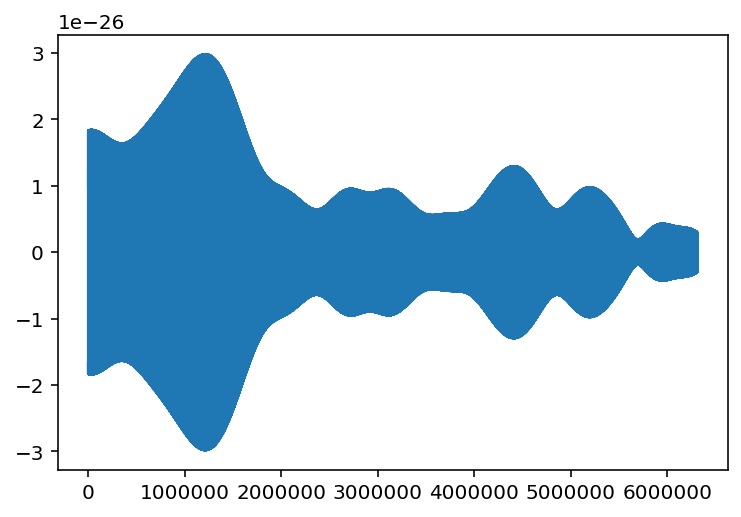

In [16]:
%matplotlib qt
plt.plot(chans[i])

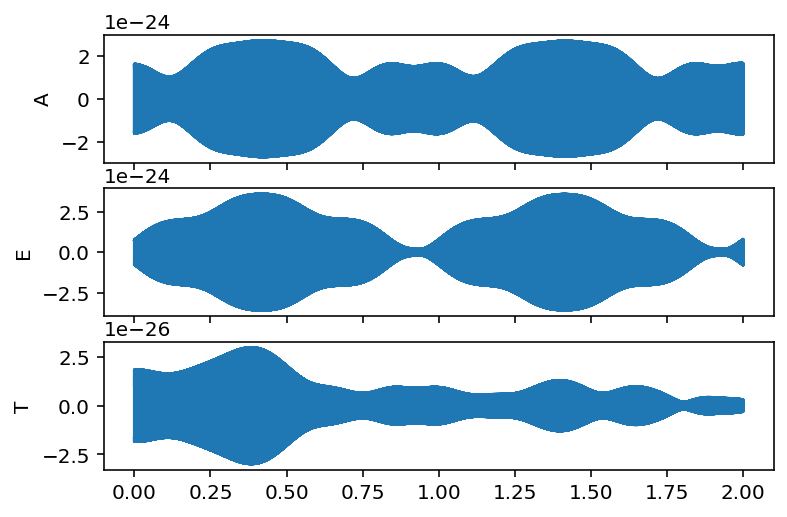

In [13]:
%matplotlib qt
fig, ax = plt.subplots(3, 1, sharex=True)

for i, lab in enumerate(["A", "E", "T"]):
    ax[i].plot(np.arange(len(chans[0])) * dt / YRSID_SI, chans[i])
    ax[i].set_ylabel(lab)

## Compare to equal armlength fit

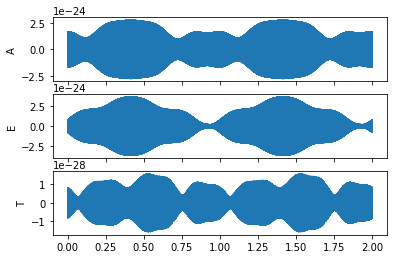

In [11]:
orbit_file_equal = "../orbit_files/equalarmlength-trailing-fit.h5"

orbit_kwargs_equal = dict(orbit_file=orbit_file_equal)

tdi_kwargs_equal = dict(
    orbit_kwargs=orbit_kwargs_equal, order=order, tdi=tdi_gen, tdi_chan="AET",
)

gb_lisa_equal = ResponseWrapper(
    gb,
    T,
    dt,
    index_lambda,
    index_beta,
    t0=t0,
    flip_hx=False,  # set to True if waveform is h+ - ihx
    use_gpu=use_gpu,
    remove_sky_coords=True,  # True if the waveform generator does not take sky coordinates
    is_ecliptic_latitude=True,  # False if using polar angle (theta)
    remove_garbage=True,  # removes the beginning of the signal that has bad information
    **tdi_kwargs_equal,
)
chans_equal = gb_lisa_equal(A, f, fdot, iota, phi0, psi, lam, beta)

fig, ax = plt.subplots(3, 1, sharex=True)

for i, lab in enumerate(["A", "E", "T"]):
    ax[i].plot(np.arange(len(chans[0])) * dt / YRSID_SI, chans_equal[i])
    ax[i].set_ylabel(lab)

## Custom TDI setup

Here is an example of the 2nd Generation TDI implementation within the code.

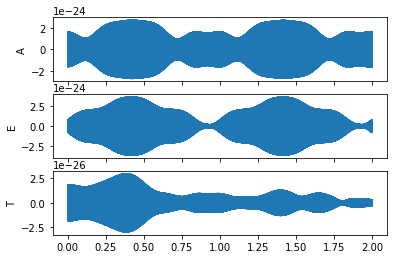

In [12]:
X1 = [
    {"link": 13, "links_for_delay": [], "sign": +1},
    {"link": 31, "links_for_delay": [13], "sign": +1},
    {"link": 12, "links_for_delay": [13, 31], "sign": +1},
    {"link": 21, "links_for_delay": [13, 31, 12], "sign": +1},
    {"link": 12, "links_for_delay": [], "sign": -1},
    {"link": 21, "links_for_delay": [12], "sign": -1},
    {"link": 13, "links_for_delay": [12, 21], "sign": -1},
    {"link": 31, "links_for_delay": [12, 21, 13], "sign": -1},
]

X2 = X1 + [
        {"link": 12, "links_for_delay": [13, 31, 12, 21], "sign": +1},
        {"link": 21, "links_for_delay": [13, 31, 12, 21, 12], "sign": +1},
        {
            "link": 13,
            "links_for_delay": [13, 31, 12, 21, 12, 21],
            "sign": +1,
        },
        {
            "link": 31,
            "links_for_delay": [13, 31, 12, 21, 12, 21, 13],
            "sign": +1,
        },
        {"link": 13, "links_for_delay": [12, 21, 13, 31], "sign": -1},
        {"link": 13, "links_for_delay": [12, 21, 13, 31, 13], "sign": -1},
        {
            "link": 13,
            "links_for_delay": [12, 21, 13, 31, 13, 31],
            "sign": -1,
        },
        {
            "link": 13,
            "links_for_delay": [12, 21, 13, 31, 13, 31, 12],
            "sign": -1,
        },
    ]

tdi_kwargs_custom = dict(
    orbit_kwargs=orbit_kwargs_esa, order=order, tdi=X2, tdi_chan="AET",
)

gb_lisa_custom = ResponseWrapper(
    gb,
    T,
    t0,
    dt,
    index_lambda,
    index_beta,
    flip_hx=False,  # set to True if waveform is h+ - ihx
    use_gpu=use_gpu,
    remove_sky_coords=True,  # True if the waveform generator does not take sky coordinates
    is_ecliptic_latitude=True,  # False if using polar angle (theta)
    remove_garbage=True,  # removes the beginning of the signal that has bad information
    **tdi_kwargs_custom,
)

chans = gb_lisa_esa(A, f, fdot, iota, phi0, psi, lam, beta)

fig, ax = plt.subplots(3, 1, sharex=True)

for i, lab in enumerate(["A", "E", "T"]):
    ax[i].plot(np.arange(len(chans[0])) * dt / YRSID_SI, chans[i])
    ax[i].set_ylabel(lab)

In [ ]:
pyresponse_tdi = pyResponseTDI(galbin.fs, galbin.size, {'orbit_file': orbits}, tdi="1st generation")
gw_flat = np.zeros((6, galbin.size))
gw_flat[0, :] = np.sin(0.01 * t)
pyresponse_tdi.y_gw_flat = gw_flat.copy()
pyresponse_tdi.y_gw_length = size
pyresponse_tdi.tdi_start_ind = 0
pyresponse_X2, pyresponse_Y2, pyresponse_Z2 = pyresponse_tdi.get_tdi_delays()